In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from catboost import CatBoostClassifier


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve,roc_auc_score

import lightgbm as lgb

from copy import copy

from itertools import accumulate

import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
root = '/Users/adriancasaisvidal/workarea/electronid/'
# root_mit = '/data/submit/lhcb/muonid/|'
signal = ur.open(root + f'monitoring-jpsiee.root:Hlt1_MCTruthElectronID/monitor_tree').arrays(library='pd')
background = ur.open(root + f'monitoring-background.root:Hlt1_MCTruthElectronID/monitor_tree').arrays(library='pd')


In [3]:
renames = {}
for key in signal.keys():
    renames[key] = key.replace('Hlt1_MCTruthElectronID__tupling_','').replace('_t','')
renames['Hlt1_MCTruthElectronID__tupling_delta_barycenter_corr_t']='track_local_max'
signal = signal.rename(columns=renames)
background =background.rename(columns=renames)

def dfeval(signal,background,toeval):
    signal.eval(toeval,inplace=True)
    background.eval(toeval,inplace=True)

dfeval(signal,background,'p=abs(1/qop)')

dfeval(signal,background,'EoP_brem = EoP*p/(p + brem_E)')

dfeval(signal,background,'delta_barycenter=delta_barycenter/1000')
dfeval(signal,background,'brem_delta_barycenter=brem_delta_barycenter/2000')
# dfeval(signal,background, 'EoP = -log(abs(EoP-1))/log(10)')
signal['EoP'] = np.clip(signal['EoP'],0,3)
background['EoP'] = np.clip(background['EoP'],0,3)


print(signal.keys())
signal.query('inECALAcc==True and brem_inECALAcc==True',inplace=True)
background.query('inECALAcc==True and brem_inECALAcc==True',inplace=True)
print(len(signal))
print(len(background))


#signal.query('pt<1000',inplace=True)
#background.query('pt<1000',inplace=True)

Index(['qop', 'pt', 'eta', 'rho', 'matched_ECAL_E', 'matched_ECAL_digit_size',
       'inECALAcc', 'brem_inECALAcc', 'EoP', 'delta_barycenter',
       'track_local_max', 'brem_delta_barycenter', 'brem_E', 'brem_local_max',
       'isElectron', 'ev', 'p', 'EoP_brem'],
      dtype='object')
2275
6233


In [4]:
signal.keys()

Index(['qop', 'pt', 'eta', 'rho', 'matched_ECAL_E', 'matched_ECAL_digit_size',
       'inECALAcc', 'brem_inECALAcc', 'EoP', 'delta_barycenter',
       'track_local_max', 'brem_delta_barycenter', 'brem_E', 'brem_local_max',
       'isElectron', 'ev', 'p', 'EoP_brem'],
      dtype='object')

In [5]:
def get_training_data(signal_df,background_df,bdt_vars):
    signal_df["category"]= 1 #Use 1 for signal
    background_df["category"] = 0 #use 0 for bkg
    training_data = pd.concat([signal_df[bdt_vars+['category']],background_df[bdt_vars+['category']]],copy=True,ignore_index=True,sort=False)
    training_data=training_data.sample(frac=1).reset_index(drop=True)
    training_data = training_data.dropna()

    return training_data
def kfold(x,y,scores=True,bdt=xgb.XGBClassifier,args={'eta':0.2,
                                                      'objective':'binary:logistic',
                                                      'n_estimators':200,
                                                      'max_depth':10,
                                                     },splits=5):
    kf = KFold(n_splits=splits)
    _,counts =np.unique(y,return_counts=True)
    if scores:
        score_bdt = copy(bdt)(**args)
        scores = cross_val_score(score_bdt,x,y,cv=kf)
    print(5*"#")
    print("Cross validation scores:")
    print(scores)
    print(5*"#")
    classifiers = []
    for tri,tti in kf.split(x):
        x_train,y_train = x.iloc[tri],y.iloc[tri]
        classifiers.append(copy(bdt)(**args))
        classifiers[-1].fit(x_train,y_train)
    return classifiers

def train_and_test(bdt,args,X,y,tensor=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    bdt = bdt(**args)
    # callbacks = [lgb.early_stopping(10, verbose=0), lgb.log_evaluation(period=0)]

    bdt.fit(X_train,y_train,
            #callbacks=callbacks
        
           )
    Sig_test = X_test[np.array(y_test,dtype='bool')]
    Bkg_test = X_test[~np.array(y_test,dtype='bool')]
    sig_train = bdt.predict_proba(X_train[np.array(y_train,dtype='bool')])[:,1]
    bkg_train = bdt.predict_proba(X_train[~np.array(y_train,dtype='bool')])[:,1]
    
    sig_test = bdt.predict_proba(Sig_test)[:,1]
    bkg_test = bdt.predict_proba(Bkg_test)[:,1]
    
   
    
    plt.hist(sig_test,bins=50,density=True,label='Signal test',color='blue',alpha=0.6)
    plt.hist(bkg_test,bins=50,density=True,label='Background test',color='red',alpha=0.6)
    
    plt.hist(sig_train,bins=50,density=True,label='Signal train',color='blue',histtype='step',alpha=0.6)
    plt.hist(bkg_train,bins=50,density=True,label='Background train',color='red',histtype='step',alpha=0.6)
    plt.legend()
    plt.savefig('overtraining.png')
    plt.show()
    
    
    cut = 0.64
    eff = 1.*np.sum(sig_test > cut)/len(sig_test)
    bkg_rej = 1 - np.sum(bkg_test > cut)/len(bkg_test)
    print("BDT")
    print(f'Signal efficiency: {eff}, True electrons: {eff*len(sig_test)}')
    print(f'Bkg rejection: {bkg_rej}, False electrons: {(1-bkg_rej)*len(bkg_test)}')
    print("")
    cut = 0.70
    eff = 1.*Sig_test.query(f'EoP>{cut}').shape[0]/Sig_test.shape[0]
    bkg_rej = 1 - Bkg_test.query(f'EoP>{cut}').shape[0]/Bkg_test.shape[0]
    print("Only EoP")
    print(f'Signal efficiency: {eff}, True electrons: {eff*Sig_test.shape[0]}')
    print(f'Bkg rejection: {bkg_rej}, False electrons: {(1-bkg_rej)*Bkg_test.shape[0]}')
    print("")
    return [bdt]
    

def performance_test(x,y,bdts,tensor=False):
    fig,ax = plt.subplots(1,1)
    sig = np.zeros(len(x[np.array(y,dtype='bool')]))
    bkg = np.zeros(len(x[~np.array(y,dtype='bool')]))
    
    for bdt in bdts:
        x_sig = x[np.array(y,dtype='bool')]
        x_bkg = x[~np.array(y,dtype='bool')]
        if not tensor:
            sig += bdt.predict_proba(x_sig)[:,1]/len(bdts)
            bkg += bdt.predict_proba(x_bkg)[:,1]/len(bdts)
        else:
            x_sig = torch.from_numpy(x_sig).float()
            x_bkg = torch.from_numpy(x_bkg).float()
            with torch.no_grad():
                sig += bdt(x_sig).squeeze().numpy()/len(bdts)
                bkg += bdt(x_bkg).squeeze().numpy()/len(bdts)
    ax.hist(sig,bins=50,density=True,label='Signal',alpha=0.7)
    ax.hist(bkg,bins=50,color='red',density=True,label='Background',alpha=0.7)
    ax.set_xlabel(r'Classifier output')
    ax.set_ylabel('A.U.')
    ax.legend()
    #fig.savefig("overtraining.pdf")
    #return [bdt]
    
def make_roc_curve(x,y,bdts,mytype='xgb'):
    fig,ax = plt.subplots(1,1)
    
    proba = np.zeros(len(x))
    for bdt in bdts:
        proba += bdt.predict_proba(x)[:,1]/len(bdts)
    fpr,tpr,_ = roc_curve(y,proba)
    ax.plot(fpr,tpr,label = f'{mytype}')
    ax.legend()
    score = roc_auc_score(y,proba)
    print(f'ROC AUC: {score}') 
    plt.savefig('roc.png')
    x['bdt'] = proba
def make_var_roc_curve(df,input_vars,mult,y):
    fig,ax = plt.subplots(1,1)
    for var,i in zip(input_vars,range(len(input_vars))):
        fpr,tpr,_ = roc_curve(y,mult[i]*df[var])
        ax.plot(fpr,tpr,label = f'{var}')
        score = roc_auc_score(y,mult[i]*df[var])
        print(f'ROC AUC {var}: {score}') 
    ax.legend()
    
    plt.savefig(f'roc-{var}.png')
    plt.legend()
    

In [6]:

mybdt= xgb.XGBClassifier
#mybdt = AdaBoostClassifier
#mybdt = CatBoostClassifier
#mybdt = lgb.sklearn.LGBMClassifier
myargs = {
         #'eta':0.01,
        'learning_rate':0.1,
          #'silent':True,
        'objective':'binary:logistic',
        #'objective':'binary:hinge',
        'n_estimators':150,
        'max_depth':5,
        'scale_pos_weight':(1.*background.shape[0]/signal.shape[0]),
        'random_state':1000,
           }




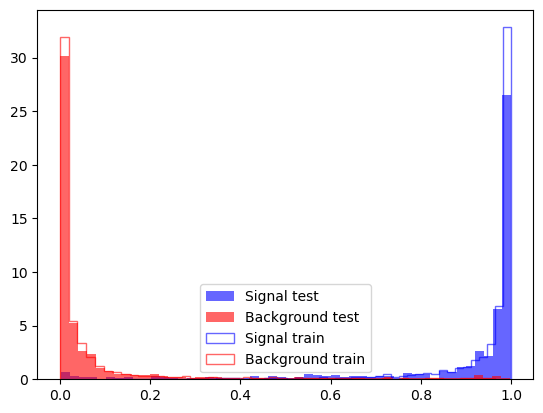

BDT
Signal efficiency: 0.8864059590316573, True electrons: 476.0
Bkg rejection: 0.944991789819376, False electrons: 66.99999999999999

Only EoP
Signal efficiency: 0.9050279329608939, True electrons: 486.0
Bkg rejection: 0.8817733990147784, False electrons: 143.99999999999997



In [7]:
#mybdt = lgb.sklearn.LGBMClassifier

features = [
    'EoP',
    'delta_barycenter',
    'track_local_max',
    'brem_delta_barycenter',
            
    
    #'EoP_brem',
    'brem_local_max'
           ]
mask = [1,-1,1,-1,1]
constraints = copy(mask)
constraints[0] = 0

# myargs = {'verbose':-1,
#           'monotone_constraints':np.array(mask),
#           'n_estimators':1000,
#           'is_unbalance':True,
#           'learning_rate':0.05,
#           'num_leaves':100,
#          'boosting_type':'gbdt',
#          'seed':1234}
#mask = [1]
training_data = get_training_data(signal,background,features)
x,y=training_data[features],training_data['category']
x_val = x.values.astype('float64')
y_val = y.values.astype('float64')

bdts = train_and_test(mybdt,myargs,x,y)

In [8]:
# Now let's do a bit of NN work

import torch
import torch.nn as nn
from monotonicnetworks.group import GroupSort
from monotonicnetworks import MonotonicWrapper, LipschitzLinear
from monotonicnetworks.functional import direct_norm , project_norm, get_normed_weights
from torch.utils.data import TensorDataset, DataLoader

from functools import partial
import json
# class Sigma(nn.Module):
#     def __init__(self,nn,sigma,monotonic_constraints):
#         super().__init__()
#         self.net = MonotonicWrapper(nn,sigma,monotonic_constraints)
#     def forward(self,x):
#         x = self.net(x)
#         x = torch.sigmoid(x)
#         return x

class Sigma(MonotonicWrapper):
    def __init__(self,nn,sigma,monotonic_constraints):
        super().__init__(nn,sigma,monotonic_constraints)
        # self.net = MonotonicWrapper
    def forward(self,x):
        x = super().forward(x)
        x = torch.sigmoid(x)
        return x
def create_full_model(DEPTH=4,
                      N_FEATURES=len(features),
                      WIDTH=16,
                      constraints = [],
                      sigma=.2,
                      linear = nn.Linear,
                      constrained=True
                      ):
    
    n_groups = WIDTH/2
    n_groups = N_FEATURES
    activation = GroupSort(WIDTH//2)
    if not constrained:
        linear = nn.Linear
    # activation = nn.Softmax()
    model = nn.Sequential()
    model.add_module('0',linear(N_FEATURES,WIDTH))
    model.add_module('0-activ',activation)
    for layer in range(1,DEPTH):
        model.add_module(f'{layer}',linear(WIDTH,WIDTH))
        model.add_module(f'{layer}-activ',activation)

    model.add_module(f'{DEPTH}',linear(WIDTH,1))
    
    if constrained:
        model = MonotonicWrapper(model,sigma,constraints)
    model_out = nn.Sequential(model,nn.Sigmoid())
   
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Model size: {pytorch_total_params}")
    return model_out

[0, -1, 1, -1, 1]
Model size: 1401


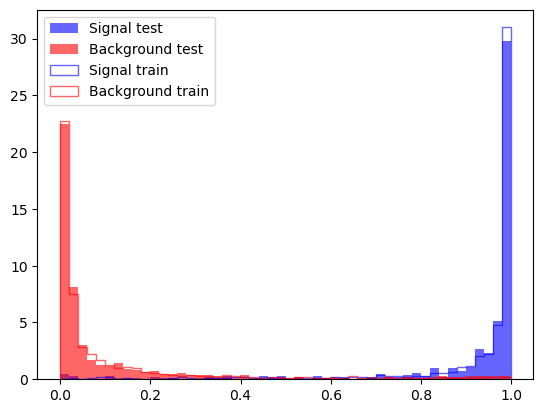

BDT
Signal efficiency: 0.9068901303538175, True electrons: 487.0
Bkg rejection: 0.9507389162561576, False electrons: 60.000000000000064

Only EoP
Signal efficiency: 0.9050279329608939, True electrons: 486.0
Bkg rejection: 0.8817733990147784, False electrons: 143.99999999999997

1 -> 0.975 AUC


In [9]:
def train_model(model,X,y,EPOCHS=50,loss_fun = torch.nn.functional.binary_cross_entropy,plot=False):
    LR = 1e-2
    LR_end = 1e-3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    Sig_test = X_test[np.array(y_test,dtype='bool')]
    Bkg_test = X_test[~np.array(y_test,dtype='bool')]
    # print(X_train)
    x_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()[:,None]
    
    x_val = torch.from_numpy(X_test).float()
    y_val = torch.from_numpy(y_test).float()[:,None]
    
    data = TensorDataset(x_train,y_train)
    loader = DataLoader(data,batch_size = 128,shuffle=True)
    GAMMA = (LR_end/LR) ** (1/len(loader)/EPOCHS)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer,gamma=GAMMA)
    
    for i in range(EPOCHS):
        model.train()
        for x,y in loader:
            output = model(x)
            #print(output)
            weights = (y==0) * y.mean() + (y==1) # account for unabalanced dataset
            loss = loss_fun(output,y,weight=weights)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    model.eval()
    with torch.no_grad():
        pred_val = model(x_val).squeeze().numpy()
        val = y_val.squeeze().numpy()
        pred_train = model(x_train).squeeze().numpy()
        train = y_train.squeeze().numpy()
    score = roc_auc_score(val,pred_val)
    
    if plot:
        mask_val = np.array(val,dtype='bool')
        sig_val = pred_val[mask_val]
        bkg_val = pred_val[~mask_val]
        
        mask_train = np.array(train,dtype='bool')
        sig_train = pred_train[mask_train]
        bkg_train = pred_train[~mask_train]
        plt.hist(sig_val,bins=50,density=True,label='Signal test',color='blue',alpha=0.6)
        plt.hist(bkg_val,bins=50,density=True,label='Background test',color='red',alpha=0.6)

        plt.hist(sig_train,bins=50,density=True,label='Signal train',color='blue',histtype='step',alpha=0.6)
        plt.hist(bkg_train,bins=50,density=True,label='Background train',color='red',histtype='step',alpha=0.6)
        plt.legend()
        plt.savefig('overtraining-nn.pdf')
        plt.show()
        
        cut = 0.75
        eff = 1.*np.sum(sig_val > cut)/len(sig_val)
        bkg_rej = 1 - np.sum(bkg_val > cut)/len(bkg_val)
        print("BDT")
        print(f'Signal efficiency: {eff}, True electrons: {eff*len(sig_val)}')
        print(f'Bkg rejection: {bkg_rej}, False electrons: {(1-bkg_rej)*len(bkg_val)}')
        print("")
        cut = 0.70
        eff = np.sum(Sig_test.T[0] > cut)/len(Sig_test.T[0])
        bkg_rej = 1 - np.sum(Bkg_test.T[0] > cut)/len(Bkg_test.T[0])
        print("Only EoP")
        print(f'Signal efficiency: {eff}, True electrons: {eff*len(Sig_test.T[0])}')
        print(f'Bkg rejection: {bkg_rej}, False electrons: {(1-bkg_rej)*len(Bkg_test.T[0])}')
        print("")
    return model,score
        
            



constraints[0]=0
constraints_in = constraints
#constraints_in = [1 for c in constraints]
#constraints_in = []

kind = 'one-inf'
linear_fun = partial(LipschitzLinear,kind=kind)
#linear_func = nn.Linear
print(constraints_in)
depth = 4
#for sigma in np.linspace(1e-3,1e-1,50):
sigma = 1
linear_fun = partial(LipschitzLinear,kind=kind,lipschitz_const=sigma)

mymodel = create_full_model(DEPTH=depth,
                            N_FEATURES=len(features),
                            #WIDTH = 3*len(features),
                            WIDTH= 20,
                            sigma=sigma,
                            constrained=True,
                            linear = linear_fun,
                            constraints = constraints_in)

mymodel,score = train_model(mymodel,x_val,y_val,plot=True,EPOCHS=50)
state_dict = mymodel.state_dict()
state_dict_copy = copy(state_dict)
weight_keys = [x for x in state_dict if "weight" in x]
for k in state_dict:
    state_dict[k] = state_dict[k].tolist()
with open('export_model.json','w') as file:
    json.dump(state_dict,file)
   
print(f"{sigma} -> {score:.3f} AUC")
#performance_test(x_val,y_val,[mymodel],tensor=True)

In [10]:
# bdts = kfold(x,y,bdt=mybdt,scores=True,
#              args=myargs,splits=3
#             )

# with open('muon_bdt.pkl', 'wb') as handle:
#     pickle.dump([features,bdts],handle)
# #performance_test(x,y,bdts)
# make_roc_curve(x,y,bdts)
# make_var_roc_curve(x,features+['bdt'],mask+[1],y)

# #xgb.plot_importance(bdts[0])
# import seaborn as sns
# plt.figure(figsize=(10, 8))
# mask = np.triu(np.ones_like(training_data[features].corr(), dtype=bool))
# sns.heatmap(training_data[features].corr(), annot=True, cmap='viridis',
#             #mask=mask,
#             fmt=".2f")
# plt.title('Correlation Matrix')
# plt.savefig('corr_matrix.png')

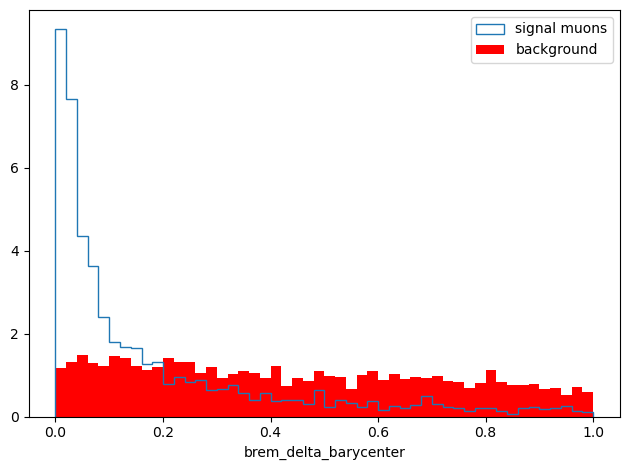

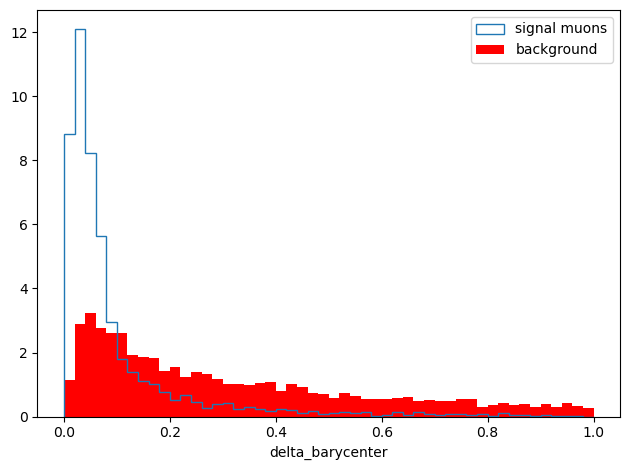

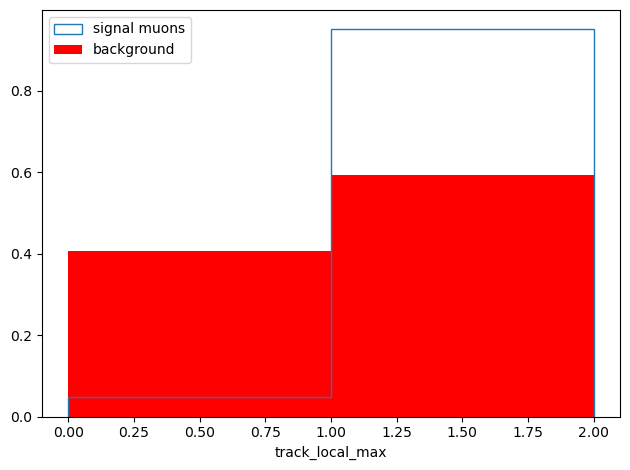

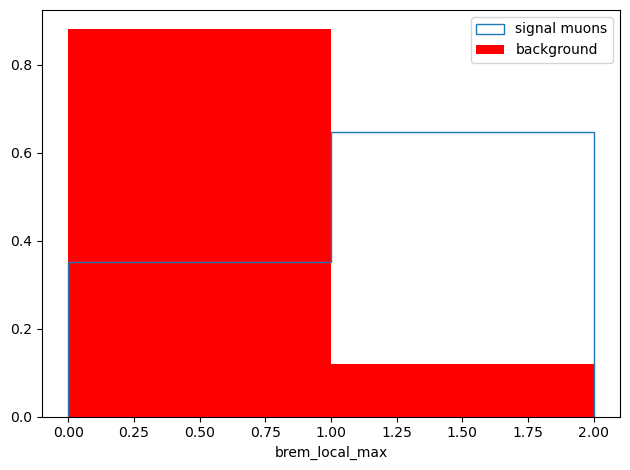

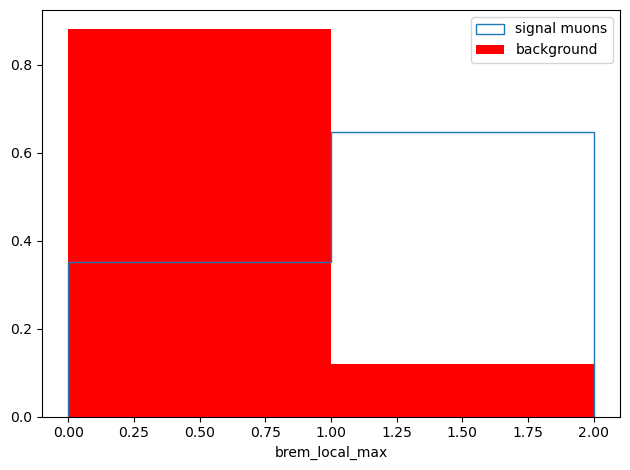

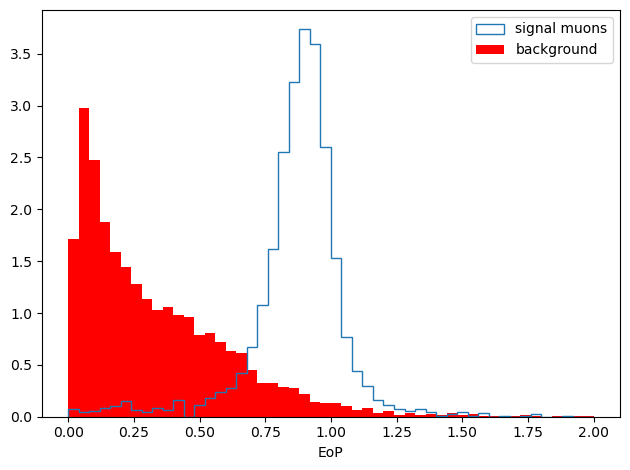

In [11]:
def compare_plot(df_s,df_b,var,w=None,discrete=False):
    if w == None or type(w)==tuple:
        myrange = w
    else:
        myrange = (-w,w)
    nbins=50
    if discrete:
        nbins=myrange[1]-myrange[0]
    plt.hist(df_s[var],bins=nbins,density=True,range=myrange,histtype='step',label='signal muons')
    plt.hist(df_b[var],bins=nbins,density=True,range=myrange,label='background',color='red')
    plt.xlabel(var)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'distributions/{var}.png')
    plt.show()
    
def hist2d(var1,var2,df,myrange=[[0,15000],[-5,5]]):
    plt.hist2d(df[var1],df[var2],bins=50,range=myrange)
    plt.show()
# hist2d('qop','chi2corr',signal,[[-10e3,10e3],[-10,10]])

# hist2d('p','bdt',signal,[[0,15000],[0,1]])
# hist2d('p','bdt',background,[[0,15000],[0,1]])

# hist2d('pt','delta_barycenter',signal,[[0,5000],[0,500]])
# hist2d('pt','delta_barycenter',background,[[300,3000],[0,500]])

# hist2d('p','delta_barycenter',signal,[[0,50000],[0,300]])
# hist2d('p','delta_barycenter',background,[[0,50000],[0,300]])
#hist2d('pt','chi2uncorr',signal,[[0,2000],[-2,6]])
#hist2d('pt','chi2corr',signal,[[0,2000],[-2,6]])

# hist2d('tx_velo','chi2corr',signal,[[0,2000],[0,300]])ssss
compare_plot(signal,background,'brem_delta_barycenter',(0,1),discrete=False)
compare_plot(signal,background,'delta_barycenter',(0,1),discrete=False)
compare_plot(signal,background,'track_local_max',(0,2),discrete=True)
compare_plot(signal,background,'brem_local_max',(0,2),discrete=True)

compare_plot(signal,background,'brem_local_max',(0,2),discrete=True)
compare_plot(signal,background,'EoP',(0,2))
